In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [3]:
path = r"/content/drive/MyDrive/TPGNN/raw_text.txt"

# The file is read and its data is stored
text = open(path, 'r').read()

# Tokenizing the text
tokens = word_tokenize(text.lower())
#Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

print("Original Tokens:", tokens)
print("Filtered Tokens (without stop words):", filtered_tokens)

tokens = filtered_tokens
# Creating a vocabulary
vocab = {word: idx for idx, (word, _) in enumerate(Counter(tokens).items())}
idx_to_word = {idx: word for word, idx in vocab.items()}

# CBOW Dataset
class CBOWDataset(Dataset):
    def __init__(self, tokens, window_size=2):
        self.tokens = tokens
        self.window_size = window_size
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        for i in range(self.window_size, len(self.tokens) - self.window_size):
            context = [self.tokens[i - j] for j in range(self.window_size, 0, -1)] + \
                      [self.tokens[i + j] for j in range(1, self.window_size + 1)]
            target = self.tokens[i]
            data.append((context, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_idx = [vocab[word] for word in context]
        target_idx = vocab[target]
        return torch.tensor(context_idx), torch.tensor(target_idx)

# CBOW Model
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(CBOWModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
embedding_dim = 16
hidden_dim = 32
learning_rate = 0.001
batch_size = 4
epochs = 50

# Create CBOW dataset and dataloader
cbow_dataset = CBOWDataset(tokens)
dataloader = DataLoader(cbow_dataset, batch_size=batch_size, shuffle=True)

# Create CBOW model
vocab_size = len(vocab)
print('Vocab size ' + str(vocab_size))
cbow_model = CBOWModel(vocab_size, embedding_dim, hidden_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cbow_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for context, target in dataloader:
        optimizer.zero_grad()
        output = cbow_model(context)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

embeddings = cbow_model.embedding.weight.data.numpy()


Original Tokens: ['during', 'my', 'second', 'month', 'of', 'nursing', 'school', ',', 'our', 'professor', 'gave', 'us', 'a', 'pop', 'quiz', '.', 'i', 'was', 'a', 'conscientious', 'student', 'and', 'had', 'breezed', 'through', 'the', 'questions', ',', 'until', 'i', 'read', 'the', 'last', 'one', ':', '“', 'what', 'is', 'the', 'first', 'name', 'of', 'the', 'woman', 'who', 'cleans', 'the', 'school', '?', '”', 'surely', 'this', 'was', 'some', 'kind', 'of', 'joke', '.', 'i', 'had', 'seen', 'the', 'cleaning', 'woman', 'several', 'times', '.', 'she', 'was', 'tall', ',', 'dark-haired', 'and', 'in', 'her', '50s', ',', 'but', 'how', 'would', 'i', 'know', 'her', 'name', '?', 'i', 'handed', 'in', 'my', 'paper', ',', 'leaving', 'the', 'last', 'question', 'blank', '.', 'before', 'class', 'ended', ',', 'one', 'student', 'asked', 'if', 'the', 'last', 'question', 'would', 'count', 'toward', 'our', 'quiz', 'grade', '.', '“', 'absolutely', ',', '”', 'said', 'the', 'professor', '.', '“', 'in', 'your', 'care

Embeddings shape: (62, 16)


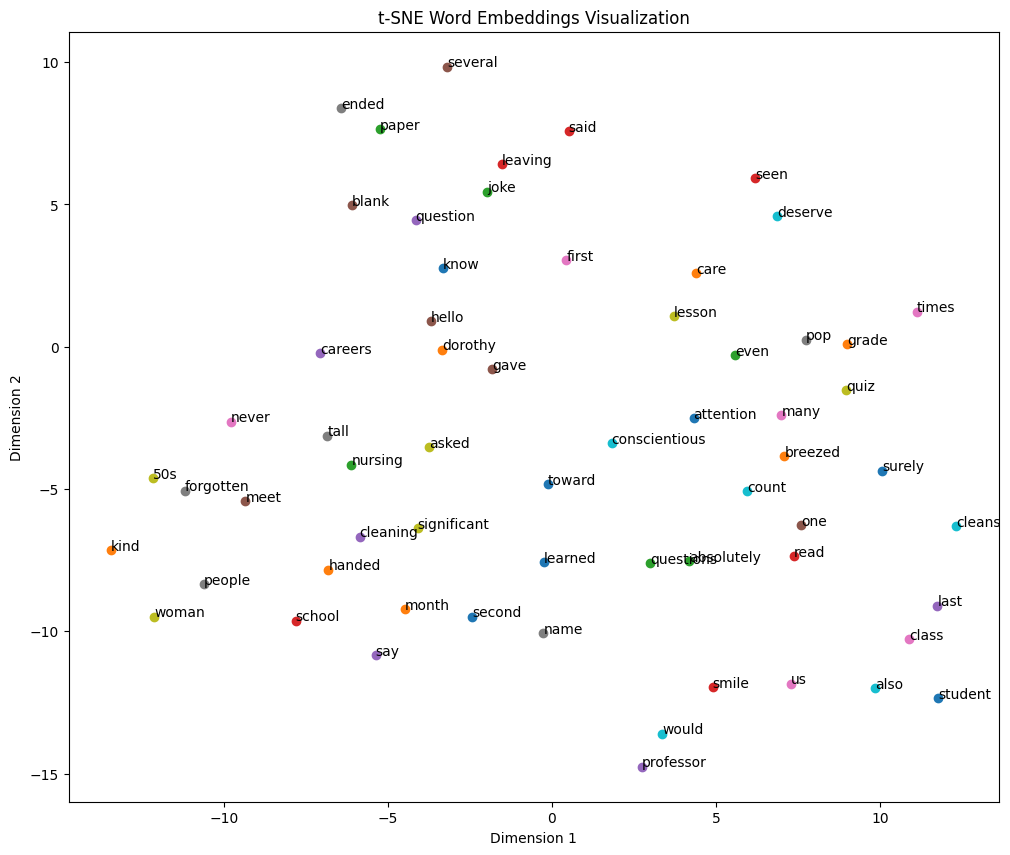

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=10)
embeddings_2d = tsne.fit_transform(embeddings)

print("Embeddings shape:", embeddings.shape)


# Plot the embeddings
plt.figure(figsize=(12, 10))
for i in range(vocab_size):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], idx_to_word[i])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Word Embeddings Visualization')
plt.show()